# Байесовский регрессор

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pymc3 as pm
from sklearn.linear_model import LinearRegression

In [2]:
# Вам будет необходимо загрузить датасет с данными о квартирах и их стоимости
# для решения задачи регрессии. 

df = pd.read_csv('flats.csv')
df.columns = ['id', 'price', 'full_sq', 'life_sq', 'num_room', 'litch_sq']
df.drop(['id'], axis=1, inplace=True)

# Лучше работать с целевой переменной, применив к ней логарифм
# После предсказания значение можно будет перевести обратно, сделав степенью экспоненты.

df['price'] = df['price'].apply(np.log, 1)

# подготовьте признаки, которые будете использовать
# life_sq, kitch_sq имеют много нулевых значений
# смещать эти значения для вычисления np.log нецелесообразно
# оставим "как есть"

df['full_sq'] = df['full_sq'].apply(lambda x: np.log(x), 1)
# df['life_sq'] = df['life_sq'].apply(lambda x: np.log(x+0.000001), 1)
# df['litch_sq'] = df['litch_sq'].apply(lambda x: np.log(x+0.000001), 1)

df.head()

,price,full_sq,life_sq,num_room,litch_sq
0,14.827111,2.397895,11.0,1.0,12.0
1,15.775605,3.806662,27.0,2.0,6.0
2,16.275099,4.343805,50.0,3.0,8.0
3,16.157316,4.025352,29.0,2.0,10.0
4,15.640060,3.433987,21.0,1.0,5.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     6042 non-null   float64
 1   full_sq   6042 non-null   float64
 2   life_sq   6042 non-null   float64
 3   num_room  6042 non-null   float64
 4   litch_sq  6042 non-null   float64
dtypes: float64(5)
memory usage: 236.1 KB


In [4]:
df.describe()

,price,full_sq,life_sq,num_room,litch_sq
count,6042.000000,6042.000000,6042.000000,6042.000000,6042.000000
mean,15.773452,3.901368,33.198941,1.997021,7.391096
std,0.692646,0.385735,20.190005,0.889523,3.806198
min,13.122363,0.000000,0.000000,0.000000,0.000000
25%,15.573368,3.637586,20.000000,1.000000,5.000000
50%,15.816991,3.828641,29.000000,2.000000,7.000000
75%,16.166886,4.143135,42.000000,3.000000,9.000000
max,18.370676,6.456770,637.000000,17.000000,96.000000


<AxesSubplot:>

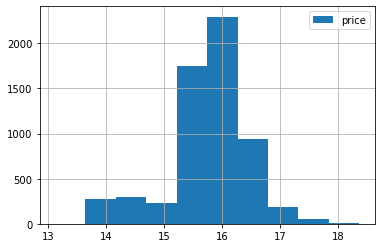

In [5]:
# Сделайте первичный анализ
df.price.hist(legend=True)

In [6]:
# и проанализируйте распределения features
# добавим np.log для full_sq

<AxesSubplot:>

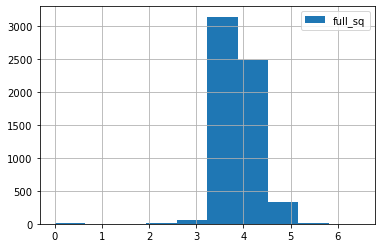

In [7]:
df.full_sq.hist(legend=True)

<AxesSubplot:>

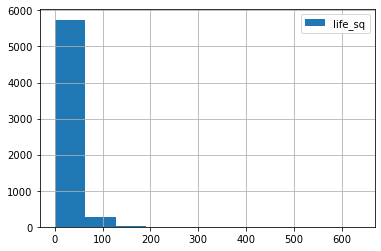

In [8]:
df.life_sq.hist(legend=True)

<AxesSubplot:>

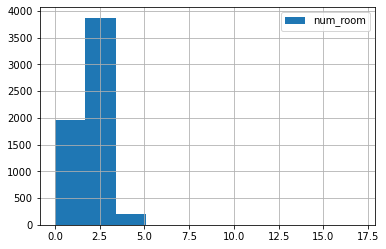

In [9]:
df.num_room.hist(legend=True)

<AxesSubplot:>

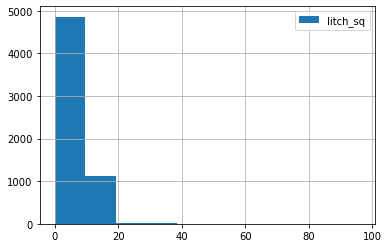

In [10]:
df.litch_sq.hist(legend=True)

In [11]:
df.corr()

,price,full_sq,life_sq,num_room,litch_sq
price,1.000000,0.501463,0.385839,0.396790,0.260095
full_sq,0.501463,1.000000,0.736847,0.742738,0.399628
life_sq,0.385839,0.736847,1.000000,0.583203,0.201836
num_room,0.396790,0.742738,0.583203,1.000000,0.181589
litch_sq,0.260095,0.399628,0.201836,0.181589,1.000000


In [12]:
X = df[['full_sq', 'life_sq', 'num_room', 'litch_sq']].values
y = df['price'].values

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/Users/user/opt/anaconda3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, litch_sq, num_room, life_sq, full_sq, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/user/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


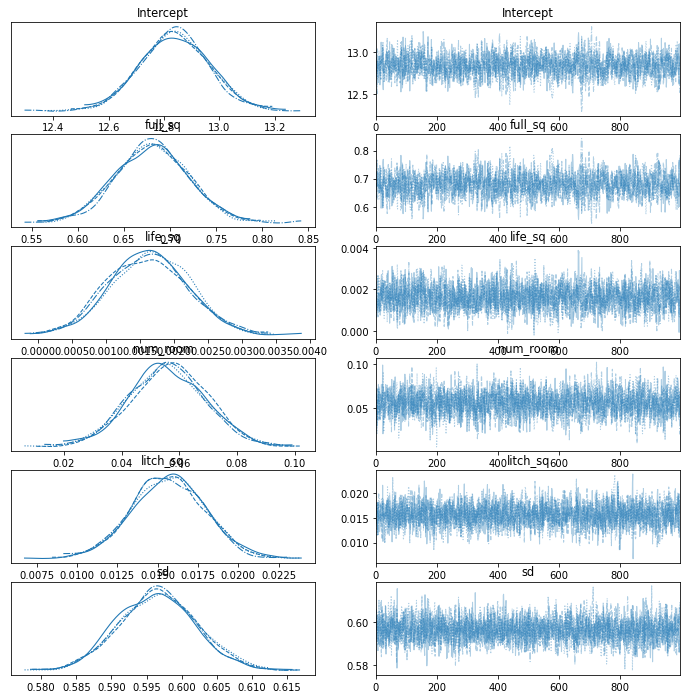

In [13]:
# Сделайте модель байесовской линейной регрессии с выбранными признаками.

with pm.Model() as linear_model:
    pm.glm.GLM.from_formula(
        'price ~ full_sq + life_sq + num_room + litch_sq ', 
        df, family = pm.glm.families.Normal()
    )
    trace = pm.sample(1000)
    
az.plot_trace(trace);

In [14]:
# На тех же самых признаках постройте линейную регрессию из sklearn

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [15]:
# сравните получившиеся коэффициенты классической линейной регрессии
# с коэффициентами при признаках в байесовской линейной регрессии
# (при помощи pm.summary(trace)

pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/user/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,12.838,0.125,12.612,13.079,0.003,0.002,1424.0,1758.0,1.0
full_sq,0.680,0.040,0.607,0.757,0.001,0.001,1345.0,1430.0,1.0
life_sq,0.002,0.001,0.001,0.003,0.000,0.000,2065.0,2431.0,1.0
num_room,0.056,0.013,0.032,0.081,0.000,0.000,2012.0,2154.0,1.0
litch_sq,0.016,0.002,0.012,0.020,0.000,0.000,2524.0,2419.0,1.0
sd,0.597,0.005,0.587,0.607,0.000,0.000,2776.0,2399.0,1.0


In [16]:
pd.DataFrame(lr.coef_, index=['full_sq', 'life_sq',  'num_room', 'kitch_sq'])

,0
full_sq,0.678830
life_sq,0.001630
num_room,0.056558
kitch_sq,0.015694
